# ECG 4-Classes Classification avec EfficientNet (PyTorch)

Ce notebook contient l'entraînement d'un modèle **EfficientNet** pour la classification d'images ECG en 4 classes.

## Fonctionnalités incluses :

1. ✅ **EfficientNet** (architecture pré-entraînée, transfer learning)
2. ✅ **Augmentation de données adaptée aux ECG** (sans rotation/flip)
3. ✅ **Gestion du déséquilibre des classes** (poids de classe dans la loss)
4. ✅ **Régularisation** (Dropout + Weight Decay)
5. ✅ **Early Stopping** (arrêt automatique)
6. ✅ **API PyTorch moderne** (torch.amp)
7. ✅ **Validation Croisée K-Fold** (entraînement robuste avec 5 folds)
8. ✅ **Analyse des erreurs** (visualisation des images mal classées)
9. ✅ **Affichage complet des résultats d'évaluation**

## Structure du dataset :
```
processed_dataset_cropped_4_classes/
  Normal/
  Myocardial_Infarction/
  Abnormal_Heartbeat/
  History_MI/
```


## 0) Setup & Configuration


In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix, classification_report
)
from collections import Counter
import random

SEED     = 42
IMG_SIZE = 224
BATCH    = 32
ROOT     = "../../Datasets/Dataset_without_background"  # Dataset avec 4 classes

# Reproducibility & GPU
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False


Device: cuda


## 1) Calcul de la moyenne et de l'écart-type (pour normalisation)


In [2]:
# Vérifier que le dossier existe
if not os.path.exists(ROOT):
    raise FileNotFoundError(f"Le dossier '{ROOT}' n'existe pas. Vérifiez le chemin.")

# Temporary transform to compute mean/std (no Normalize yet)
tx_tmp = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # EfficientNet attend 3 canaux
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),           # -> [0,1]
])

ds_tmp = datasets.ImageFolder(ROOT, transform=tx_tmp)
print(f"Dataset trouvé: {len(ds_tmp)} images dans {len(ds_tmp.classes)} classes")
print(f"Classes: {ds_tmp.classes}")

# Calculer la distribution des classes pour le déséquilibre
class_counts = Counter(ds_tmp.targets)
print(f"\nDistribution des classes:")
for i, class_name in enumerate(ds_tmp.classes):
    count = class_counts[i]
    print(f"  {class_name:25s}: {count:4d} images ({count/len(ds_tmp)*100:.1f}%)")

loader_tmp = DataLoader(ds_tmp, batch_size=128, num_workers=min(8, os.cpu_count() or 1), shuffle=False)

psum = 0.0
psum_sq = 0.0
count = 0

for x, _ in loader_tmp:
    b = x.size(0)        # [B,3,H,W]
    x = x.view(b, -1)
    psum    += x.sum()
    psum_sq += (x**2).sum()
    count   += x.numel()

mean = (psum / count).item()
std  = ((psum_sq / count - mean**2) ** 0.5).item()
print(f"\nmean={mean:.6f}, std={std:.6f}")


Dataset trouvé: 928 images dans 4 classes
Classes: ['ECG Images of Myocardial Infarction Patients', 'ECG Images of Patient that have History of MI', 'ECG Images of Patient that have abnormal heartbeat', 'Normal Person ECG Images']

Distribution des classes:
  ECG Images of Myocardial Infarction Patients:  239 images (25.8%)
  ECG Images of Patient that have History of MI:  172 images (18.5%)
  ECG Images of Patient that have abnormal heartbeat:  233 images (25.1%)
  Normal Person ECG Images :  284 images (30.6%)

mean=0.971065, std=0.100863


## 2) Calcul des poids de classe pour gérer le déséquilibre


In [3]:
# Calculer les poids de classe pour gérer le déséquilibre
total_samples = len(ds_tmp)
n_classes = len(ds_tmp.classes)
class_weights = []

for i in range(n_classes):
    count = class_counts[i]
    weight = total_samples / (n_classes * count)
    class_weights.append(weight)

class_weights = torch.FloatTensor(class_weights).to(device)
print("Poids de classe calculés:")
for i, class_name in enumerate(ds_tmp.classes):
    print(f"  {class_name:25s}: {class_weights[i]:.4f}")

print(f"\nLes classes avec moins d'échantillons auront un poids plus élevé dans la loss.")


Poids de classe calculés:
  ECG Images of Myocardial Infarction Patients: 0.9707
  ECG Images of Patient that have History of MI: 1.3488
  ECG Images of Patient that have abnormal heartbeat: 0.9957
  Normal Person ECG Images : 0.8169

Les classes avec moins d'échantillons auront un poids plus élevé dans la loss.


## 3) Dataset avec augmentation de données adaptée aux ECG


In [4]:
MEAN, STD = mean, std

# Classe pour ajouter du bruit gaussien
class AddGaussianNoise:
    """Ajoute un bruit gaussien léger à l'image"""
    def __init__(self, std=0.01):
        self.std = std
    
    def __call__(self, x):
        return torch.clamp(x + torch.randn_like(x) * self.std, 0, 1)

# Transformations pour validation/test (sans augmentation)
tx_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # EfficientNet attend 3 canaux
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([MEAN]*3, [STD]*3),
])

# Transformations pour training (AVEC augmentation adaptée aux ECG)
tx_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomAffine(degrees=0, translate=(0, 0.05), fill=0),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    AddGaussianNoise(std=0.01),
    transforms.Normalize([MEAN]*3, [STD]*3),
])

# Charger dataset avec transformations de base pour le split
ds_tmp = datasets.ImageFolder(ROOT, transform=tx_val)
print(f"Dataset chargé: {len(ds_tmp)} images")
print(f"Classes: {ds_tmp.classes}")
y  = np.array(ds_tmp.targets)
idx = np.arange(len(ds_tmp))

# Séparer un petit test set final (10%)
idx_cv, idx_te, y_cv, y_te = train_test_split(
    idx, y, test_size=0.10, random_state=SEED, stratify=y
)

print(f"Données pour cross-validation: {len(idx_cv)} images")
print(f"Test set final: {len(idx_te)} images")

import platform
is_windows = platform.system() == 'Windows'
num_workers = 0 if is_windows else min(4, os.cpu_count() or 1)
pin = (device.type == "cuda")
use_persistent_workers = False

# Créer le test set final
test_ds = datasets.ImageFolder(ROOT, transform=tx_val)
test_set = Subset(test_ds, idx_te)
test_loader = DataLoader(test_set, batch_size=BATCH, shuffle=False,
                         num_workers=num_workers, pin_memory=pin, 
                         persistent_workers=use_persistent_workers)

print("Classes:", ds_tmp.classes, ds_tmp.class_to_idx)


Dataset chargé: 928 images
Classes: ['ECG Images of Myocardial Infarction Patients', 'ECG Images of Patient that have History of MI', 'ECG Images of Patient that have abnormal heartbeat', 'Normal Person ECG Images']
Données pour cross-validation: 835 images
Test set final: 93 images
Classes: ['ECG Images of Myocardial Infarction Patients', 'ECG Images of Patient that have History of MI', 'ECG Images of Patient that have abnormal heartbeat', 'Normal Person ECG Images'] {'ECG Images of Myocardial Infarction Patients': 0, 'ECG Images of Patient that have History of MI': 1, 'ECG Images of Patient that have abnormal heartbeat': 2, 'Normal Person ECG Images': 3}


## 4) Modèle EfficientNet avec Transfer Learning


In [5]:
import torch.nn as nn
from torchvision.models import efficientnet_b0

NUM_CLASSES = len(ds_tmp.classes)  # 4 classes

# Charger EfficientNet-B0 pré-entraîné sur ImageNet
def create_efficientnet(num_classes=NUM_CLASSES, dropout_rate=0.2):
    """
    Crée un modèle EfficientNet-B0 avec transfer learning.
    - Utilise les poids pré-entraînés sur ImageNet
    - Remplace le classificateur final pour 4 classes
    - Ajoute du dropout pour la régularisation
    """
    model = efficientnet_b0(weights='IMAGENET1K_V1')
    
    # Modifier le classificateur final
    # EfficientNet-B0 a 1280 features en sortie
    # Le classificateur est déjà un Sequential avec [Dropout, Linear]
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate, inplace=True),
        nn.Linear(num_features, num_classes)
    )
    
    return model

model = create_efficientnet(num_classes=NUM_CLASSES, dropout_rate=0.2).to(device)

# Utiliser CrossEntropyLoss avec les poids de classe
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer avec weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning-rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=False)

print(f"Modèle EfficientNet-B0 créé avec {NUM_CLASSES} classes: {ds_tmp.classes}")
print(f"Nombre de paramètres: {sum(p.numel() for p in model.parameters()):,}")
print(f"Paramètres entraînables: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Modèle EfficientNet-B0 créé avec 4 classes: ['ECG Images of Myocardial Infarction Patients', 'ECG Images of Patient that have History of MI', 'ECG Images of Patient that have abnormal heartbeat', 'Normal Person ECG Images']
Nombre de paramètres: 4,012,672
Paramètres entraînables: 4,012,672


C:\Users\ilias\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
from torch.amp import autocast, GradScaler
import time

K_FOLDS = 5
EPOCHS = 100
PATIENCE = 10

print(f"🔬 Démarrage de l'entraînement avec validation croisée {K_FOLDS}-fold...")
print(f"   Dataset pour CV: {len(idx_cv)} images")
print(f"   Test set final: {len(idx_te)} images")
print(f"   Chaque fold: ~{len(idx_cv)//K_FOLDS} images pour validation\n")

cv_indices = idx_cv
cv_labels = y_cv
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

def epoch_pass(model, loader, device, optimizer=None, criterion=None, scaler=None):
    train_mode = optimizer is not None
    if train_mode:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    n_samples  = 0
    n_correct  = 0

    use_amp = (device.type == "cuda") and (scaler is not None)
    dtype = torch.float16 if use_amp else torch.float32

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        bs = xb.size(0)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            if use_amp:
                with autocast(device_type='cuda', dtype=dtype):
                    logits = model(xb)
                    loss   = criterion(logits, yb)
            else:
                logits = model(xb)
                loss   = criterion(logits, yb)
            
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
        else:
            if use_amp:
                with torch.no_grad(), autocast(device_type='cuda', dtype=dtype):
                    logits = model(xb)
                    loss   = criterion(logits, yb)
            else:
                with torch.no_grad():
                    logits = model(xb)
                    loss   = criterion(logits, yb)

        preds = logits.argmax(dim=1)
        n_correct  += (preds == yb).sum().item()
        n_samples  += bs
        total_loss += loss.item() * bs

    mean_loss = total_loss / max(1, n_samples)
    acc = n_correct / max(1, n_samples)
    return mean_loss, acc

all_fold_histories = []
cv_results = {
    'fold': [],
    'best_val_loss': [],
    'best_val_acc': [],
    'best_epoch': [],
    'train_size': [],
    'val_size': []
}

best_global_model = None
best_global_val_loss = float('inf')

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(cv_indices, cv_labels), 1):
    print(f"\n{'='*60}")
    print(f"Fold {fold_idx}/{K_FOLDS}")
    print(f"{'='*60}")
    print(f"Train: {len(train_idx)} images | Val: {len(val_idx)} images")
    
    train_fold_ds = datasets.ImageFolder(ROOT, transform=tx_train)
    val_fold_ds = datasets.ImageFolder(ROOT, transform=tx_val)
    
    train_fold_indices = [cv_indices[i] for i in train_idx]
    val_fold_indices = [cv_indices[i] for i in val_idx]
    
    train_fold_set = Subset(train_fold_ds, train_fold_indices)
    val_fold_set = Subset(val_fold_ds, val_fold_indices)
    
    train_fold_loader = DataLoader(train_fold_set, batch_size=BATCH, shuffle=True,
                                   num_workers=num_workers, pin_memory=pin, 
                                   persistent_workers=use_persistent_workers)
    val_fold_loader = DataLoader(val_fold_set, batch_size=BATCH, shuffle=False,
                                num_workers=num_workers, pin_memory=pin, 
                                persistent_workers=use_persistent_workers)
    
    fold_model = create_efficientnet(num_classes=NUM_CLASSES, dropout_rate=0.2).to(device)
    fold_criterion = nn.CrossEntropyLoss(weight=class_weights)
    fold_optimizer = torch.optim.Adam(fold_model.parameters(), lr=1e-4, weight_decay=1e-4)
    fold_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        fold_optimizer, mode='min', factor=0.5, patience=3, verbose=False
    )
    scaler = GradScaler('cuda' if device.type == "cuda" else 'cpu', enabled=(device.type == "cuda"))
    
    fold_history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    
    best_val = float('inf')
    best_state = None
    patience_counter = 0
    
    start_time = time.time()
    
    for epoch in range(1, EPOCHS + 1):
        tr_loss, tr_acc = epoch_pass(fold_model, train_fold_loader, device, 
                                     optimizer=fold_optimizer, criterion=fold_criterion, scaler=scaler)
        va_loss, va_acc = epoch_pass(fold_model, val_fold_loader, device, 
                                     optimizer=None, criterion=fold_criterion, scaler=None)
        
        fold_history["train_loss"].append(tr_loss)
        fold_history["val_loss"].append(va_loss)
        fold_history["train_acc"].append(tr_acc)
        fold_history["val_acc"].append(va_acc)
        
        fold_scheduler.step(va_loss)
        current_lr = fold_optimizer.param_groups[0]['lr']
        
        if epoch % 5 == 0 or epoch == 1:
            print(f"  [{epoch:03d}/{EPOCHS}] "
                  f"train_loss={tr_loss:.4f} train_acc={tr_acc*100:.2f}% "
                  f"val_loss={va_loss:.4f}   val_acc={va_acc*100:.2f}% "
                  f"lr={current_lr:.6f}")
        
        if va_loss < best_val:
            best_val = va_loss
            patience_counter = 0
            best_state = {
                "epoch": epoch,
                "model": fold_model.state_dict(),
                "val_loss": va_loss,
                "val_acc": va_acc
            }
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"  ⚠️ Early stopping déclenché après {PATIENCE} epochs sans amélioration")
                break
    
    elapsed_time = time.time() - start_time
    
    if best_state is not None:
        fold_model.load_state_dict(best_state["model"])
    
    all_fold_histories.append(fold_history)
    cv_results['fold'].append(fold_idx)
    cv_results['best_val_loss'].append(best_state['val_loss'] if best_state else va_loss)
    cv_results['best_val_acc'].append(best_state['val_acc'] if best_state else va_acc)
    cv_results['best_epoch'].append(best_state['epoch'] if best_state else epoch)
    cv_results['train_size'].append(len(train_fold_indices))
    cv_results['val_size'].append(len(val_fold_indices))
    
    if best_state and best_state['val_loss'] < best_global_val_loss:
        best_global_val_loss = best_state['val_loss']
        best_global_model = fold_model.state_dict()
    
    print(f"✅ Fold {fold_idx} terminé en {elapsed_time:.1f}s")
    print(f"   Best Val Loss: {best_state['val_loss']:.4f} | Best Val Acc: {best_state['val_acc']*100:.2f}% (epoch {best_state['epoch']})")

print(f"\n{'='*60}")
print("📊 RÉSULTATS DE LA VALIDATION CROISÉE")
print(f"{'='*60}")
print(f"\nMétriques moyennes sur {K_FOLDS} folds:")
print(f"  Val Loss: {np.mean(cv_results['best_val_loss']):.4f} ± {np.std(cv_results['best_val_loss']):.4f}")
print(f"  Val Acc:  {np.mean(cv_results['best_val_acc'])*100:.2f}% ± {np.std(cv_results['best_val_acc'])*100:.2f}%")
print(f"\nDétails par fold:")
for i in range(K_FOLDS):
    print(f"  Fold {cv_results['fold'][i]}: Loss={cv_results['best_val_loss'][i]:.4f}, "
          f"Acc={cv_results['best_val_acc'][i]*100:.2f}%, "
          f"Epoch={cv_results['best_epoch'][i]}")

if best_global_model is not None:
    os.makedirs("checkpoints", exist_ok=True)
    best_checkpoint = {
        "model": best_global_model,
        "num_classes": NUM_CLASSES,
        "class_names": ds_tmp.classes,
        "cv_mean_val_loss": np.mean(cv_results['best_val_loss']),
        "cv_mean_val_acc": np.mean(cv_results['best_val_acc']),
        "cv_std_val_loss": np.std(cv_results['best_val_loss']),
        "cv_std_val_acc": np.std(cv_results['best_val_acc']),
        "cv_results": cv_results,
        "class_weights": class_weights.cpu().numpy()
    }
    torch.save(best_checkpoint, "checkpoints/best_efficientnet_4_classes.pt")
    print(f"\n✅ Meilleur modèle sauvegardé (val_loss: {best_global_val_loss:.4f})")
    print("Checkpoint sauvegardé: checkpoints/best_efficientnet_4_classes.pt")
    
    model.load_state_dict(best_global_model)
else:
    print("\n⚠️ Attention: Aucun modèle n'a été sauvegardé")

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

max_epochs = max(len(h["train_loss"]) for h in all_fold_histories)
for epoch in range(max_epochs):
    train_losses = [h["train_loss"][epoch] for h in all_fold_histories if epoch < len(h["train_loss"])]
    val_losses = [h["val_loss"][epoch] for h in all_fold_histories if epoch < len(h["val_loss"])]
    train_accs = [h["train_acc"][epoch] for h in all_fold_histories if epoch < len(h["train_acc"])]
    val_accs = [h["val_acc"][epoch] for h in all_fold_histories if epoch < len(h["val_acc"])]
    
    if train_losses:
        history["train_loss"].append(np.mean(train_losses))
        history["val_loss"].append(np.mean(val_losses))
        history["train_acc"].append(np.mean(train_accs))
        history["val_acc"].append(np.mean(val_accs))


C:\Users\ilias\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🔬 Démarrage de l'entraînement avec validation croisée 5-fold...
   Dataset pour CV: 835 images
   Test set final: 93 images
   Chaque fold: ~167 images pour validation


Fold 1/5
Train: 668 images | Val: 167 images
  [001/100] train_loss=1.2978 train_acc=40.12% val_loss=1.3866   val_acc=25.15% lr=0.000100
  [005/100] train_loss=0.3992 train_acc=86.98% val_loss=1.3450   val_acc=32.93% lr=0.000100
  [010/100] train_loss=0.1726 train_acc=93.71% val_loss=1.2841   val_acc=32.34% lr=0.000100
  [015/100] train_loss=0.0777 train_acc=98.20% val_loss=1.2083   val_acc=48.50% lr=0.000100
  [020/100] train_loss=0.0615 train_acc=98.05% val_loss=0.9781   val_acc=61.68% lr=0.000100
  [025/100] train_loss=0.0341 train_acc=99.10% val_loss=0.8116   val_acc=69.46% lr=0.000100
  [030/100] train_loss=0.0485 train_acc=98.80% val_loss=0.9363   val_acc=59.28% lr=0.000100
  [035/100] train_loss=0.0232 train_acc=99.70% val_loss=0.6012   val_acc=80.24% lr=0.000050
  [040/100] train_loss=0.0124 train_acc=99.70% va

KeyboardInterrupt: 

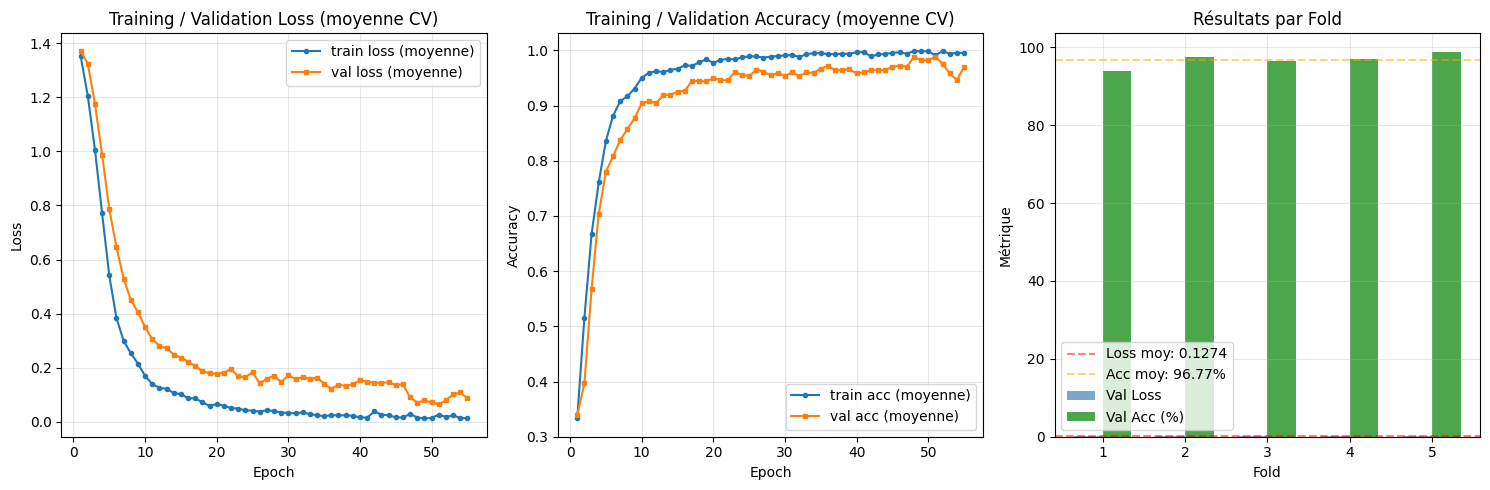

In [ ]:
epochs = np.arange(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, history["train_loss"], label="train loss (moyenne)", marker='o', markersize=3)
plt.plot(epochs, history["val_loss"],   label="val loss (moyenne)", marker='s', markersize=3)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation Loss (moyenne CV)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(epochs, history["train_acc"], label="train acc (moyenne)", marker='o', markersize=3)
plt.plot(epochs, history["val_acc"],   label="val acc (moyenne)", marker='s', markersize=3)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training / Validation Accuracy (moyenne CV)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
x_pos = np.arange(len(cv_results['fold']))
width = 0.35
plt.bar(x_pos - width/2, cv_results['best_val_loss'], width, label='Val Loss', alpha=0.7, color='steelblue')
plt.bar(x_pos + width/2, [acc*100 for acc in cv_results['best_val_acc']], width, label='Val Acc (%)', alpha=0.7, color='green')
plt.axhline(np.mean(cv_results['best_val_loss']), color='red', linestyle='--', alpha=0.5, label=f'Loss moy: {np.mean(cv_results["best_val_loss"]):.4f}')
plt.axhline(np.mean(cv_results['best_val_acc'])*100, color='orange', linestyle='--', alpha=0.5, label=f'Acc moy: {np.mean(cv_results["best_val_acc"])*100:.2f}%')
plt.xlabel('Fold')
plt.ylabel('Métrique')
plt.title('Résultats par Fold')
plt.xticks(x_pos, cv_results['fold'])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7) Évaluation finale


In [ ]:
from torch.amp import autocast

@torch.no_grad()
def evaluate_multiclass(model, loader, device, class_names):
    model.eval()
    all_preds, all_targets, all_probs = [], [], []
    use_amp = (device.type == "cuda")
    dtype = torch.float16 if use_amp else torch.float32
    
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        
        if use_amp:
            with autocast(device_type='cuda', dtype=dtype):
                logits = model(xb)
        else:
            logits = model(xb)
        
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()
        
        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(yb.cpu().numpy())

    y_true = np.concatenate(all_targets, axis=0)
    y_pred = np.concatenate(all_preds, axis=0)
    y_prob = np.concatenate(all_probs, axis=0)

    acc = accuracy_score(y_true, y_pred)
    
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    except:
        auc = None
    
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    
    return {
        "accuracy": acc,
        "precision_per_class": prec,
        "recall_per_class": rec,
        "f1_per_class": f1,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "precision_weighted": prec_weighted,
        "recall_weighted": rec_weighted,
        "f1_weighted": f1_weighted,
        "auc": auc,
        "confusion_matrix": cm,
        "report": report,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob
    }

checkpoint_path = "checkpoints/best_efficientnet_4_classes.pt"
if os.path.exists(checkpoint_path):
    best_ckpt = torch.load(checkpoint_path, map_location=device, weights_only=False)
    if "model" in best_ckpt:
        model.load_state_dict(best_ckpt["model"])
        class_names = best_ckpt.get("class_names", ds_tmp.classes)
        print(f"✅ Modèle chargé depuis le checkpoint (CV mean val_loss: {best_ckpt.get('cv_mean_val_loss', 'N/A'):.4f})\n")
    else:
        class_names = ds_tmp.classes
else:
    class_names = ds_tmp.classes

print("="*60)
print("ÉVALUATION FINALE SUR LE TEST SET")
print("="*60)
metrics = evaluate_multiclass(model, test_loader, device, class_names)

print("\n" + "="*60)
print("RÉSULTATS D'ÉVALUATION")
print("="*60)
print(f"\n📊 Métriques globales:")
print(f"  Accuracy : {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"\n📈 Métriques macro-moyennes:")
print(f"  Precision: {metrics['precision_macro']:.4f}")
print(f"  Recall   : {metrics['recall_macro']:.4f}")
print(f"  F1-Score : {metrics['f1_macro']:.4f}")
if metrics['auc'] is not None:
    print(f"  AUC      : {metrics['auc']:.4f}")

print(f"\n📋 Métriques par classe:")
print(f"{'Classe':<30} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 66)
for i, class_name in enumerate(class_names):
    print(f"{class_name:<30} {metrics['precision_per_class'][i]:<12.4f} "
          f"{metrics['recall_per_class'][i]:<12.4f} {metrics['f1_per_class'][i]:<12.4f}")

print(f"\n📊 Matrice de confusion:")
print(metrics["confusion_matrix"])

print(f"\n📄 Rapport de classification détaillé:")
print(metrics["report"])


✅ Modèle chargé depuis le checkpoint (CV mean val_loss: 0.1274)

ÉVALUATION FINALE SUR LE TEST SET

RÉSULTATS D'ÉVALUATION

📊 Métriques globales:
  Accuracy : 0.9462 (94.62%)

📈 Métriques macro-moyennes:
  Precision: 0.9502
  Recall   : 0.9457
  F1-Score : 0.9433

📋 Métriques par classe:
Classe                         Precision    Recall       F1-Score    
------------------------------------------------------------------
Abnormal_Heartbeat             1.0000       0.7826       0.8780      
History_MI                     0.8947       1.0000       0.9444      
Myocardial_Infarction          1.0000       1.0000       1.0000      
Normal                         0.9062       1.0000       0.9508      

📊 Matrice de confusion:
[[18  2  0  3]
 [ 0 17  0  0]
 [ 0  0 24  0]
 [ 0  0  0 29]]

📄 Rapport de classification détaillé:
                       precision    recall  f1-score   support

   Abnormal_Heartbeat     1.0000    0.7826    0.8780        23
           History_MI     0.8947    1.0000

## 8) Visualisation de la matrice de confusion


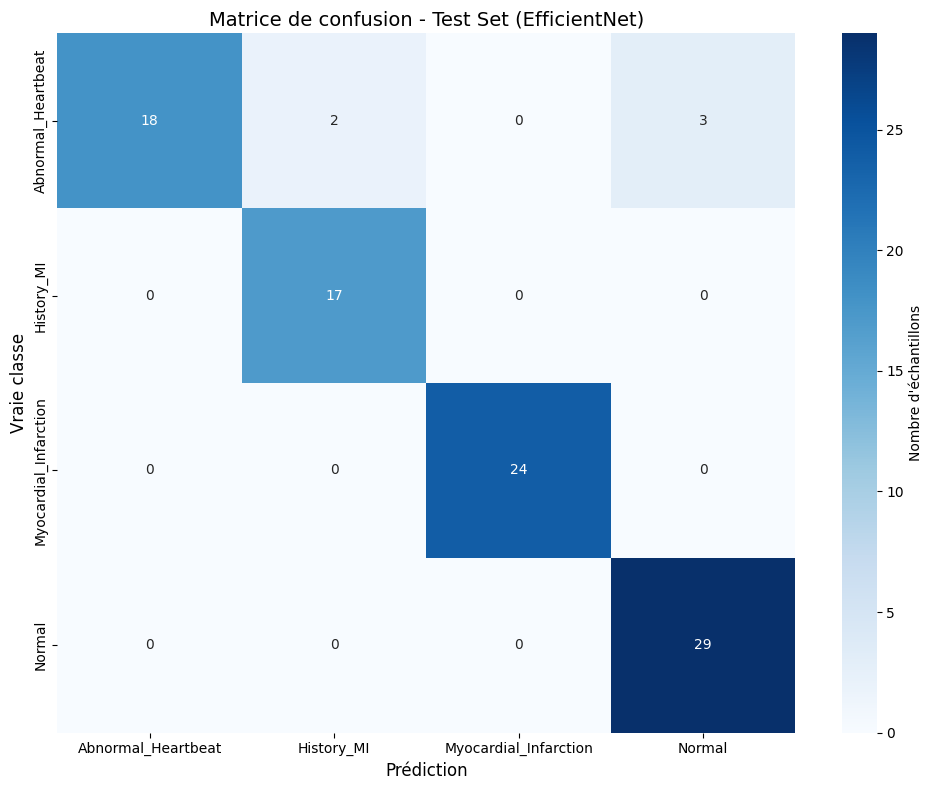

In [ ]:
import seaborn as sns

cm = metrics['confusion_matrix']
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Nombre d\'échantillons'})
plt.xlabel('Prédiction', fontsize=12)
plt.ylabel('Vraie classe', fontsize=12)
plt.title('Matrice de confusion - Test Set (EfficientNet)', fontsize=14)
plt.tight_layout()
plt.show()
